# STL-10 Classification: Logistic Regression Analysis

## 📊 **Project Overview**
This notebook focuses on training and evaluating Logistic Regression models for classifying STL-10 images into 5 classes: airplane, bird, car, cat, and deer.

### **Dataset Summary**
- **Classes:** 5 categories (airplane, bird, car, cat, deer)
- **Training samples:** [Number] images
- **Test samples:** [Number] images
- **Features:** 200 PCA components (reduced from 4096)
- **Preprocessing:** Grayscale, CLAHE, Gaussian blur, PCA

### **Objectives**
1. Train baseline Logistic Regression model
2. Optimize hyperparameters using grid search
3. Evaluate model performance
4. Analyze results and misclassifications

---

## **Cell 1: Import Libraries**

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           precision_score, recall_score, f1_score, roc_auc_score, 
                           roc_curve, auc, ConfusionMatrixDisplay)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Utilities
import joblib
import warnings
import time
from datetime import datetime
import os

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


# Load Preprocessed Data

In [2]:
def load_processed_data(data_path='../data/processed'):
    """
    Load preprocessed data from saved files
    
    Returns:
        X_train, X_test, y_train, y_test, class_names
    """
    print("📂 Loading preprocessed data...")
    
    # Load data arrays
    X_train = np.load(f'{data_path}/X_train_pca.npy')
    X_test = np.load(f'{data_path}/X_test_pca.npy')
    y_train = np.load(f'{data_path}/y_train.npy')
    y_test = np.load(f'{data_path}/y_test.npy')
    class_names = np.load(f'{data_path}/class_names.npy', allow_pickle=True)
    
    # Load models (optional, for transforming new data)
    scaler = joblib.load('../models/scaler.pkl')
    pca = joblib.load('../models/pca_model.pkl')
    
    print(f"✅ Data loaded successfully!")
    print(f"   Training set: {X_train.shape} - {len(y_train)} samples")
    print(f"   Test set: {X_test.shape} - {len(y_test)} samples")
    print(f"   Classes: {list(class_names)}")
    print(f"   PCA explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")
    
    return X_train, X_test, y_train, y_test, class_names, scaler, pca

# Load the data
X_train, X_test, y_train, y_test, class_names, scaler, pca = load_processed_data()

📂 Loading preprocessed data...
✅ Data loaded successfully!
   Training set: (5200, 200) - 5200 samples
   Test set: (1300, 200) - 1300 samples
   Classes: [np.str_('airplane'), np.str_('bird'), np.str_('car'), np.str_('cat'), np.str_('deer')]
   PCA explained variance: 0.8800


# Exploratory Data Analysis

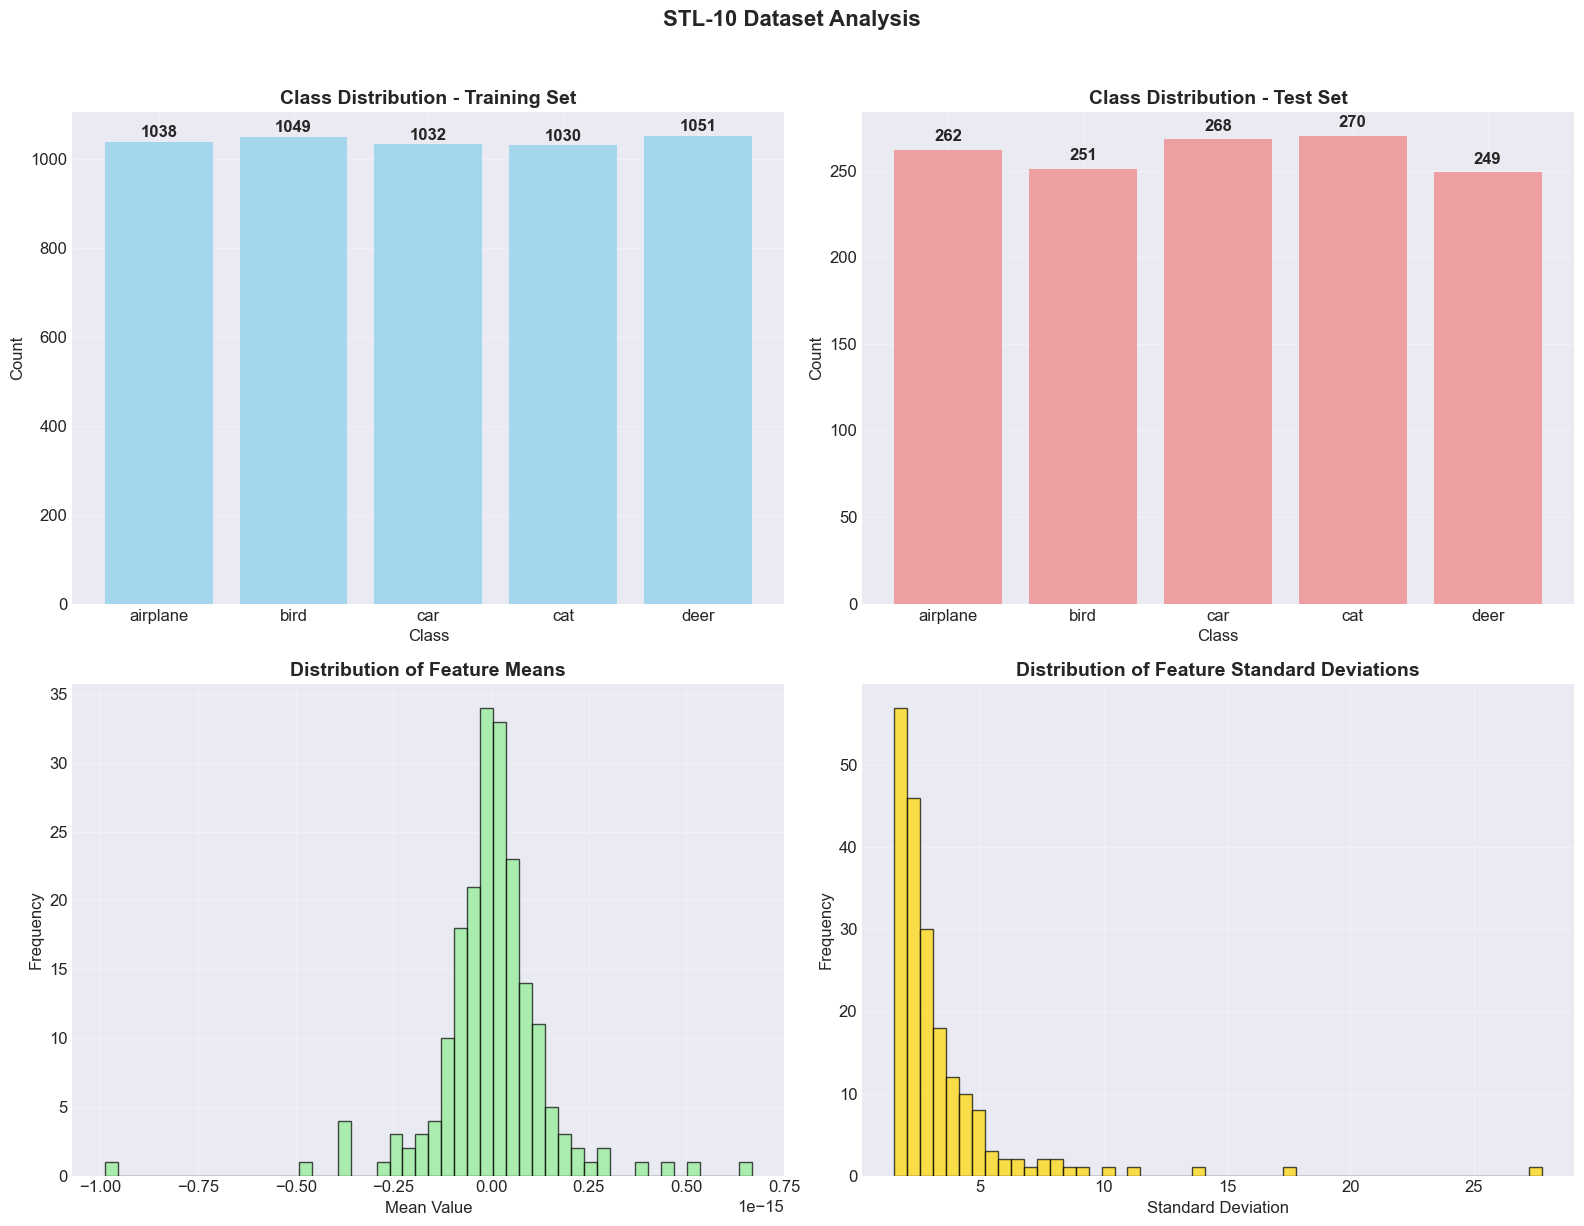

📊 Dataset Statistics:
   Training set size: 5200 samples
   Test set size: 1300 samples
   Number of features: 200
   Number of classes: 5
   Class balance (training): 99.04%


In [3]:
def explore_data_distribution(X_train, X_test, y_train, y_test, class_names):
    """
    Explore and visualize the data distribution
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Class distribution in training set
    train_counts = np.bincount(y_train)
    axes[0, 0].bar(class_names, train_counts, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Class Distribution - Training Set', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(True, alpha=0.3)
    
    for i, count in enumerate(train_counts):
        axes[0, 0].text(i, count + 10, str(count), ha='center', fontweight='bold')
    
    # 2. Class distribution in test set
    test_counts = np.bincount(y_test)
    axes[0, 1].bar(class_names, test_counts, color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Class Distribution - Test Set', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Class')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].grid(True, alpha=0.3)
    
    for i, count in enumerate(test_counts):
        axes[0, 1].text(i, count + 5, str(count), ha='center', fontweight='bold')
    
    # 3. Feature statistics
    feature_means = np.mean(X_train, axis=0)
    feature_stds = np.std(X_train, axis=0)
    
    axes[1, 0].hist(feature_means, bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Distribution of Feature Means', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Mean Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].hist(feature_stds, bins=50, color='gold', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Distribution of Feature Standard Deviations', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Standard Deviation')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('STL-10 Dataset Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("📊 Dataset Statistics:")
    print(f"   Training set size: {len(X_train)} samples")
    print(f"   Test set size: {len(X_test)} samples")
    print(f"   Number of features: {X_train.shape[1]}")
    print(f"   Number of classes: {len(class_names)}")
    print(f"   Class balance (training): {np.min(train_counts)/np.mean(train_counts):.2%}")
    
    return train_counts, test_counts

# Run exploration
train_counts, test_counts = explore_data_distribution(X_train, X_test, y_train, y_test, class_names)

# Baseline Logistic Regression

🏗️ Training Baseline Logistic Regression...
✅ Baseline Model Trained in 5.24 seconds

📈 Performance Metrics:
   Accuracy:  0.4462
   Precision: 0.4452
   Recall:    0.4462
   F1-Score:  0.4455

📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.53      0.53      0.53       262
        bird       0.31      0.32      0.32       251
         car       0.69      0.71      0.70       268
         cat       0.34      0.31      0.33       270
        deer       0.34      0.35      0.35       249

    accuracy                           0.45      1300
   macro avg       0.44      0.44      0.44      1300
weighted avg       0.45      0.45      0.45      1300



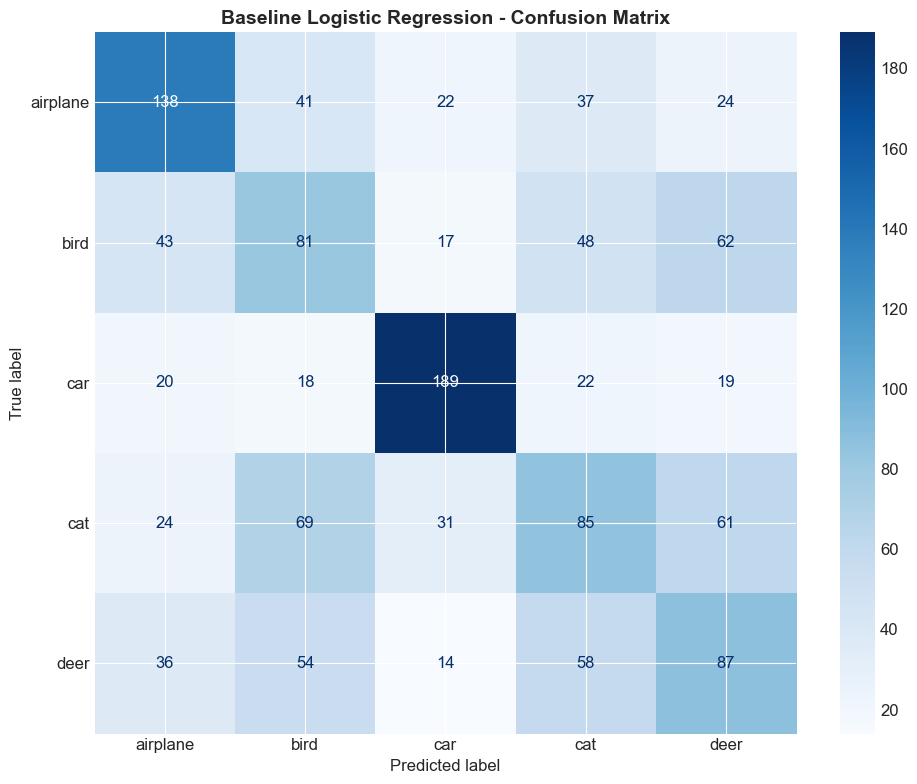

In [4]:
def train_baseline_model(X_train, y_train, X_test, y_test, class_names):
    """
    Train and evaluate a baseline Logistic Regression model
    """
    print("🏗️ Training Baseline Logistic Regression...")
    print("="*60)
    
    # Start timer
    start_time = time.time()
    
    # Create and train baseline model
    baseline_model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1,  # Use all available cores
        verbose=0
    )
    
    # Train the model
    baseline_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = baseline_model.predict(X_test)
    y_pred_proba = baseline_model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # End timer
    training_time = time.time() - start_time
    
    # Display results
    print(f"✅ Baseline Model Trained in {training_time:.2f} seconds")
    print(f"\n📈 Performance Metrics:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    print(f"\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    display_cm.plot(cmap='Blues', ax=ax, values_format='d')
    ax.set_title('Baseline Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return baseline_model, y_pred, y_pred_proba, accuracy, training_time

# Train baseline model
baseline_model, y_pred_base, y_pred_proba_base, acc_base, time_base = train_baseline_model(
    X_train, y_train, X_test, y_test, class_names
)

# Optimized Logistic Regression with Hyperparameter Tuning

⚙️ Optimizing Logistic Regression with Hyperparameter Tuning
🔍 Performing Randomized Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Hyperparameter tuning completed in 55.67 seconds

🎯 Best Parameters Found:
   solver: saga
   penalty: elasticnet
   max_iter: 500
   l1_ratio: 0.5
   class_weight: balanced
   C: 0.01

📊 Cross-Validation Results:
   Best CV Score: 0.4610
   Number of CV Folds: 3

📈 Test Set Performance:
   Accuracy:  0.4692
   Precision: 0.4647
   Recall:    0.4692
   F1-Score:  0.4665

📊 Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.52      0.57      0.55       262
        bird       0.34      0.33      0.33       251
         car       0.74      0.75      0.74       268
         cat       0.35      0.32      0.33       270
        deer       0.35      0.37      0.36       249

    accuracy                           0.47      1300
   macro avg       0.46      0.47      0.46      1300

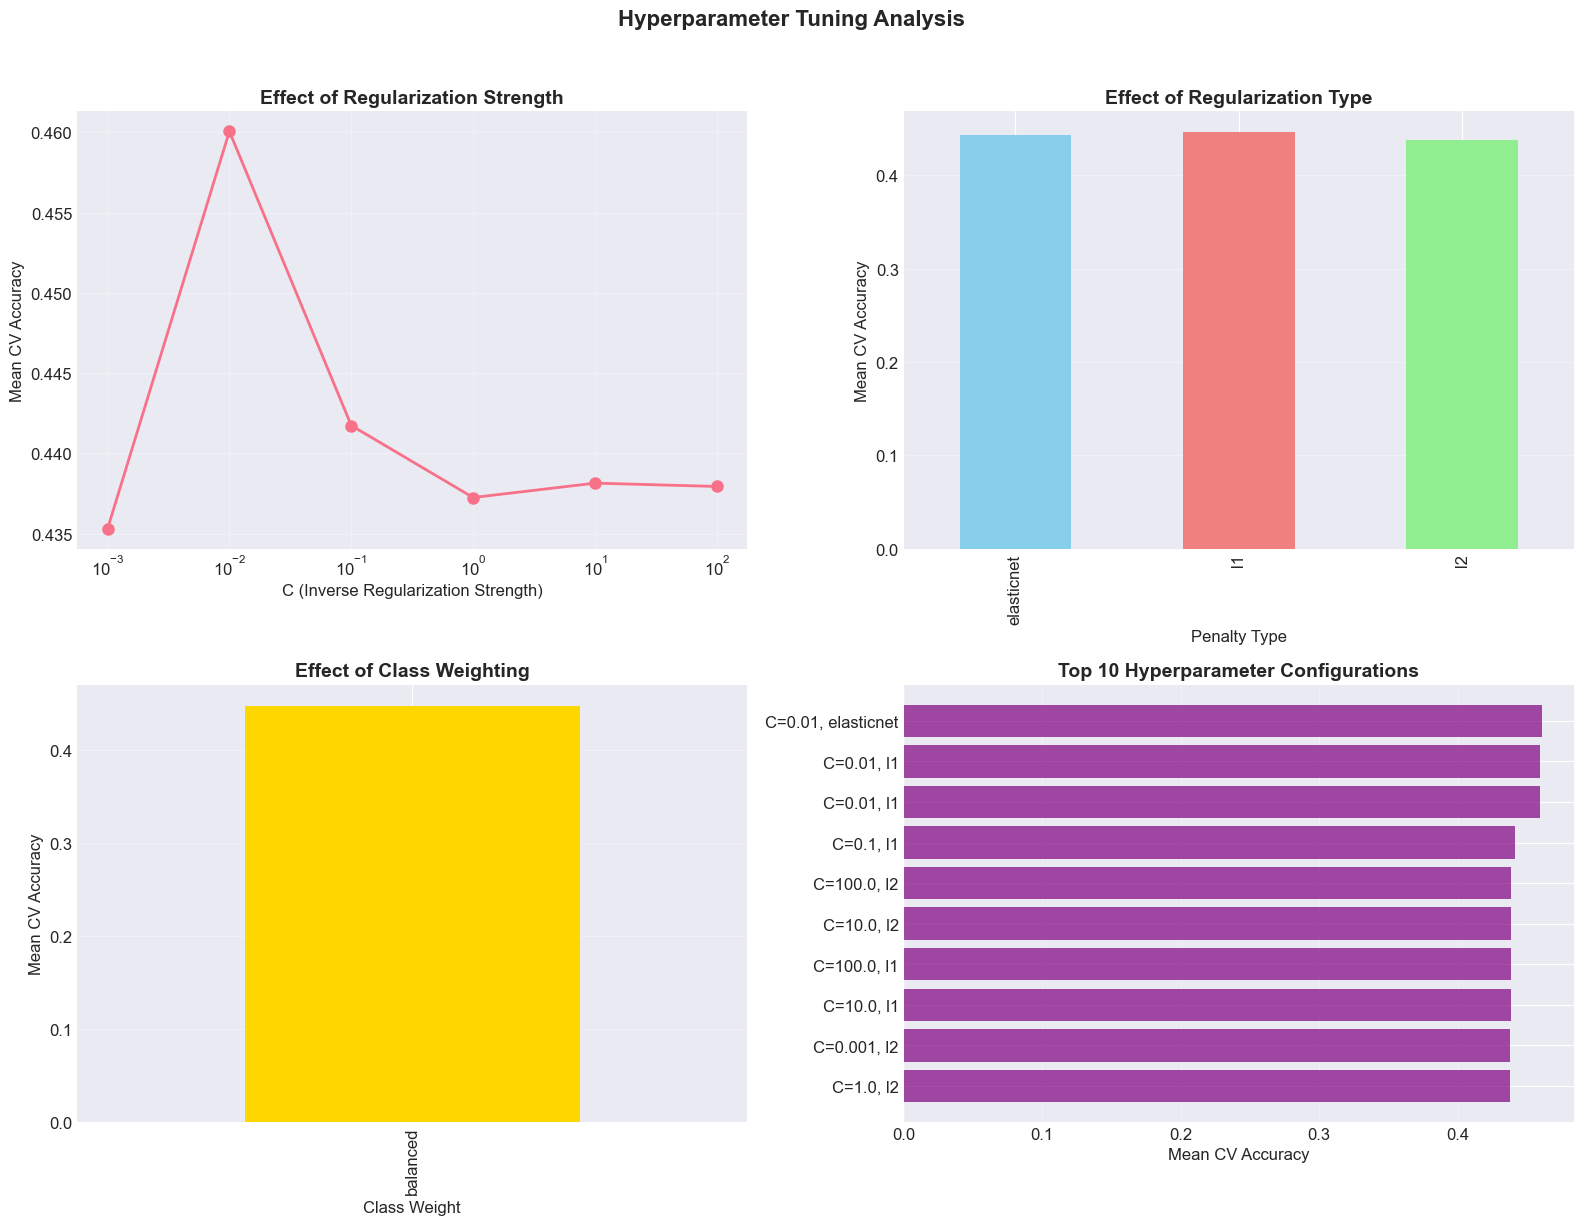

In [5]:
def optimize_logistic_regression(X_train, y_train, X_test, y_test, class_names):
    """
    Optimize Logistic Regression using Grid Search with comprehensive evaluation
    """
    print("⚙️ Optimizing Logistic Regression with Hyperparameter Tuning")
    print("="*70)
    
    # Start timer
    start_time = time.time()
    
    # Define parameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse regularization strength
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['liblinear', 'saga', 'lbfgs'],
        'max_iter': [500, 1000, 1500],
        'class_weight': [None, 'balanced'],
        'l1_ratio': [0.1, 0.5, 0.9]  # For elasticnet only
    }
    
    # Create base model
    base_model = LogisticRegression(random_state=42, n_jobs=-1)
    
    # Use RandomizedSearchCV for faster exploration
    print("🔍 Performing Randomized Search...")
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=20,  # Number of random combinations
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=2,
        return_train_score=True
    )
    
    # Fit the model
    random_search.fit(X_train, y_train)
    
    # Get results
    search_time = time.time() - start_time
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    print(f"\n✅ Hyperparameter tuning completed in {search_time:.2f} seconds")
    print(f"\n🎯 Best Parameters Found:")
    for param, value in best_params.items():
        print(f"   {param}: {value}")
    
    # Cross-validation results
    cv_results = random_search.cv_results_
    print(f"\n📊 Cross-Validation Results:")
    print(f"   Best CV Score: {random_search.best_score_:.4f}")
    print(f"   Number of CV Folds: {3}")
    
    # Evaluate on test set
    y_pred_opt = best_model.predict(X_test)
    y_pred_proba_opt = best_model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_opt)
    precision = precision_score(y_test, y_pred_opt, average='weighted')
    recall = recall_score(y_test, y_pred_opt, average='weighted')
    f1 = f1_score(y_test, y_pred_opt, average='weighted')
    
    print(f"\n📈 Test Set Performance:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    print(f"\n📊 Detailed Classification Report:")
    print(classification_report(y_test, y_pred_opt, target_names=class_names))
    
    # Visualize parameter performance
    plot_hyperparameter_performance(cv_results)
    
    return best_model, y_pred_opt, y_pred_proba_opt, accuracy, search_time, random_search

def plot_hyperparameter_performance(cv_results):
    """
    Visualize the performance of different hyperparameters
    """
    # Extract results
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    # Create DataFrame for analysis
    results_df = pd.DataFrame(params)
    results_df['mean_test_score'] = mean_test_scores
    results_df = results_df.sort_values('mean_test_score', ascending=False)
    
    # Plot top 10 configurations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. C parameter vs accuracy
    c_scores = results_df.groupby('C')['mean_test_score'].mean()
    axes[0, 0].plot(c_scores.index, c_scores.values, 'o-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('C (Inverse Regularization Strength)', fontsize=12)
    axes[0, 0].set_ylabel('Mean CV Accuracy', fontsize=12)
    axes[0, 0].set_title('Effect of Regularization Strength', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xscale('log')
    
    # 2. Penalty type comparison
    penalty_scores = results_df.groupby('penalty')['mean_test_score'].mean()
    penalty_scores.plot(kind='bar', ax=axes[0, 1], color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0, 1].set_xlabel('Penalty Type', fontsize=12)
    axes[0, 1].set_ylabel('Mean CV Accuracy', fontsize=12)
    axes[0, 1].set_title('Effect of Regularization Type', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Class weight comparison
    class_weight_scores = results_df.groupby('class_weight')['mean_test_score'].mean()
    class_weight_scores.plot(kind='bar', ax=axes[1, 0], color=['gold', 'lightblue'])
    axes[1, 0].set_xlabel('Class Weight', fontsize=12)
    axes[1, 0].set_ylabel('Mean CV Accuracy', fontsize=12)
    axes[1, 0].set_title('Effect of Class Weighting', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Top 10 configurations
    top_10 = results_df.head(10)
    x_pos = np.arange(len(top_10))
    axes[1, 1].barh(x_pos, top_10['mean_test_score'], color='purple', alpha=0.7)
    axes[1, 1].set_yticks(x_pos)
    
    # Create labels for configurations
    labels = []
    for _, row in top_10.iterrows():
        label = f"C={row['C']}, {row['penalty']}"
        labels.append(label)
    
    axes[1, 1].set_yticklabels(labels)
    axes[1, 1].set_xlabel('Mean CV Accuracy', fontsize=12)
    axes[1, 1].set_title('Top 10 Hyperparameter Configurations', fontsize=14, fontweight='bold')
    axes[1, 1].invert_yaxis()  # Highest on top
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    plt.suptitle('Hyperparameter Tuning Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return results_df

# Run optimization
best_model, y_pred_opt, y_pred_proba_opt, acc_opt, time_opt, search_cv = optimize_logistic_regression(
    X_train, y_train, X_test, y_test, class_names
)

In [6]:
# ================== Cell 5.5: Cross-Validation for Final Model ==================
print("🔍 Performing Cross-Validation for Final Model Evaluation")
print("="*70)

from sklearn.model_selection import cross_val_score, cross_val_predict

# Use the best model parameters from grid search
final_model = LogisticRegression(**best_model.get_params())

# 5-fold cross-validation
cv_scores = cross_val_score(final_model, X_train, y_train, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                           scoring='accuracy',
                           n_jobs=-1)

print(f"\n📊 5-Fold Cross-Validation Results:")
print(f"   Individual fold scores: {cv_scores.round(4)}")
print(f"   Mean CV accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"   Min/Max: {cv_scores.min():.4f}/{cv_scores.max():.4f}")

# Cross-validation predictions for ROC analysis
y_pred_cv = cross_val_predict(final_model, X_train, y_train, 
                             cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                             method='predict_proba')

print(f"\n✅ Cross-validation completed with {5} folds")
print(f"   Training/Validation ratio: 80%/20% per fold")

🔍 Performing Cross-Validation for Final Model Evaluation

📊 5-Fold Cross-Validation Results:
   Individual fold scores: [0.4596 0.451  0.476  0.449  0.476 ]
   Mean CV accuracy: 0.4623 (±0.0117)
   Min/Max: 0.4490/0.4760

✅ Cross-validation completed with 5 folds
   Training/Validation ratio: 80%/20% per fold


# Model Comparison and Analysis

📊 Model Comparison Analysis

📈 Performance Comparison:
           Accuracy  Precision  Recall  F1-Score
Baseline     0.4462     0.4452  0.4462    0.4455
Optimized    0.4692     0.4647  0.4692    0.4665

📈 Percentage Improvement:
   Accuracy: +5.17%
   Precision: +4.38%
   Recall: +5.17%
   F1-Score: +4.71%


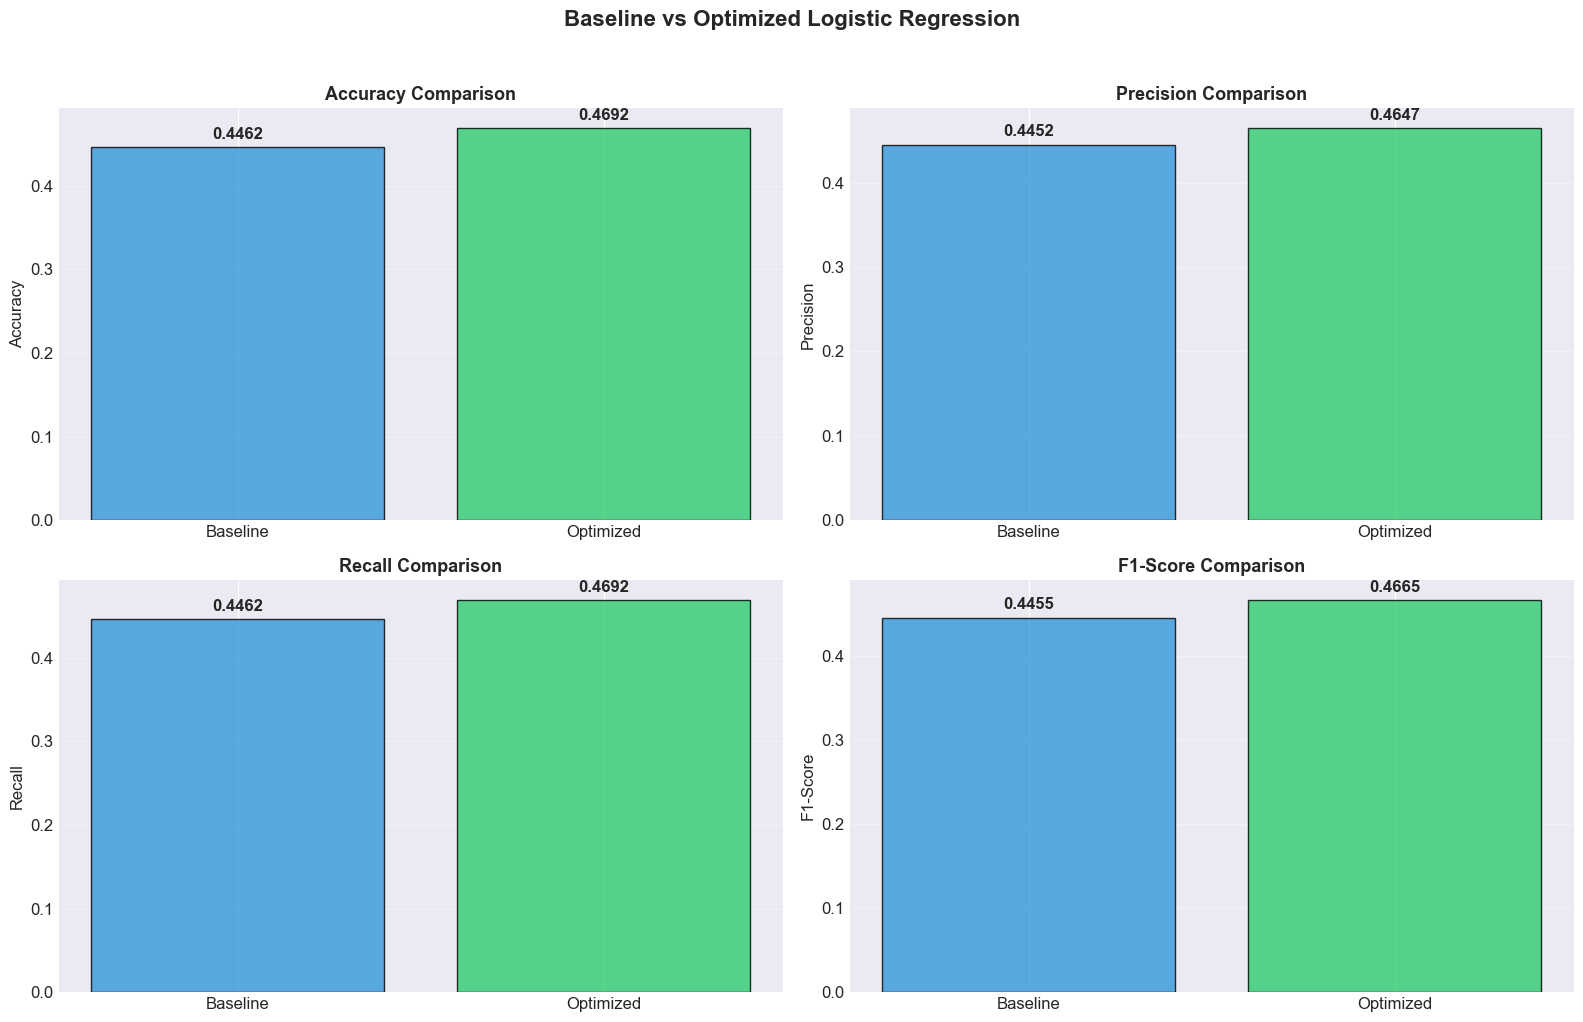

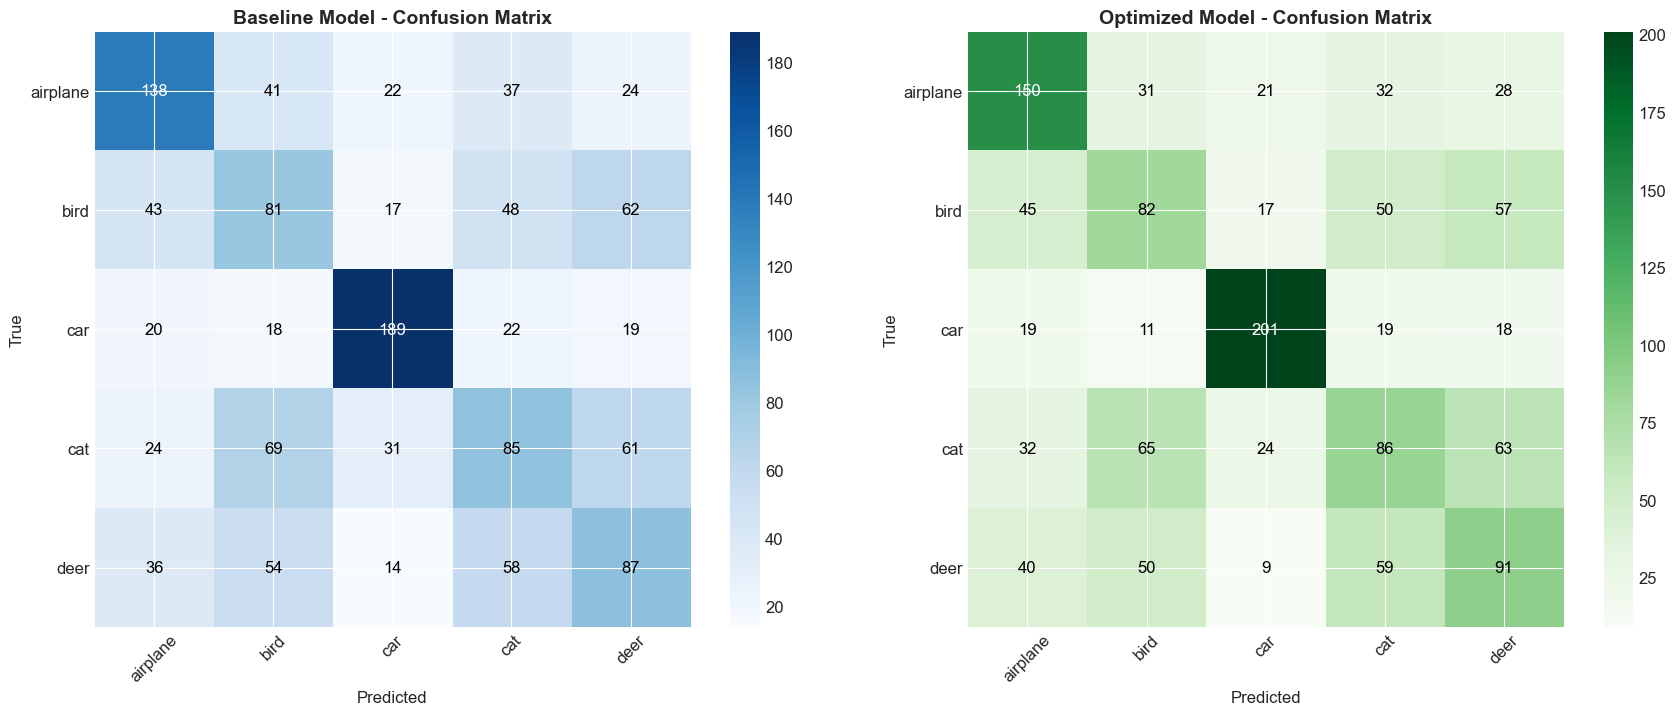

In [7]:
def compare_models(baseline_model, optimized_model, y_pred_base, y_pred_opt):
    """
    Compare baseline and optimized models
    """
    print("📊 Model Comparison Analysis")
    print("="*60)
    
    # Calculate metrics for both models
    metrics_base = {
        'Accuracy': accuracy_score(y_test, y_pred_base),
        'Precision': precision_score(y_test, y_pred_base, average='weighted'),
        'Recall': recall_score(y_test, y_pred_base, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred_base, average='weighted')
    }
    
    metrics_opt = {
        'Accuracy': accuracy_score(y_test, y_pred_opt),
        'Precision': precision_score(y_test, y_pred_opt, average='weighted'),
        'Recall': recall_score(y_test, y_pred_opt, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred_opt, average='weighted')
    }
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Baseline': metrics_base,
        'Optimized': metrics_opt
    }).T
    
    print("\n📈 Performance Comparison:")
    print(comparison_df.round(4))
    
    # Calculate improvement
    improvement = ((comparison_df.loc['Optimized'] - comparison_df.loc['Baseline']) / 
                   comparison_df.loc['Baseline'] * 100)
    print(f"\n📈 Percentage Improvement:")
    for metric, value in improvement.items():
        print(f"   {metric}: {value:+.2f}%")
    
    # Visual comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['#3498db', '#2ecc71']
    
    for idx, metric in enumerate(metrics_list):
        row = idx // 2
        col = idx % 2
        
        # Bar chart
        axes[row, col].bar(['Baseline', 'Optimized'], 
                          [metrics_base[metric], metrics_opt[metric]],
                          color=colors, alpha=0.8, edgecolor='black')
        
        axes[row, col].set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
        axes[row, col].set_ylabel(metric)
        axes[row, col].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, value in enumerate([metrics_base[metric], metrics_opt[metric]]):
            axes[row, col].text(i, value + 0.01, f'{value:.4f}', 
                              ha='center', fontweight='bold')
    
    plt.suptitle('Baseline vs Optimized Logistic Regression', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Confusion Matrix Comparison
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    cm_base = confusion_matrix(y_test, y_pred_base)
    cm_opt = confusion_matrix(y_test, y_pred_opt)
    
    # Baseline confusion matrix
    im1 = axes[0].imshow(cm_base, interpolation='nearest', cmap='Blues')
    axes[0].set_title('Baseline Model - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_xticks(np.arange(len(class_names)))
    axes[0].set_yticks(np.arange(len(class_names)))
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_yticklabels(class_names)
    plt.colorbar(im1, ax=axes[0])
    
    # Add text annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            axes[0].text(j, i, cm_base[i, j],
                        ha="center", va="center",
                        color="white" if cm_base[i, j] > cm_base.max()/2 else "black")
    
    # Optimized confusion matrix
    im2 = axes[1].imshow(cm_opt, interpolation='nearest', cmap='Greens')
    axes[1].set_title('Optimized Model - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_xticks(np.arange(len(class_names)))
    axes[1].set_yticks(np.arange(len(class_names)))
    axes[1].set_xticklabels(class_names, rotation=45)
    axes[1].set_yticklabels(class_names)
    plt.colorbar(im2, ax=axes[1])
    
    # Add text annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            axes[1].text(j, i, cm_opt[i, j],
                        ha="center", va="center",
                        color="white" if cm_opt[i, j] > cm_opt.max()/2 else "black")
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Compare models
comparison_df = compare_models(baseline_model, best_model, y_pred_base, y_pred_opt)

📈 Generating ROC Curves and AUC Scores


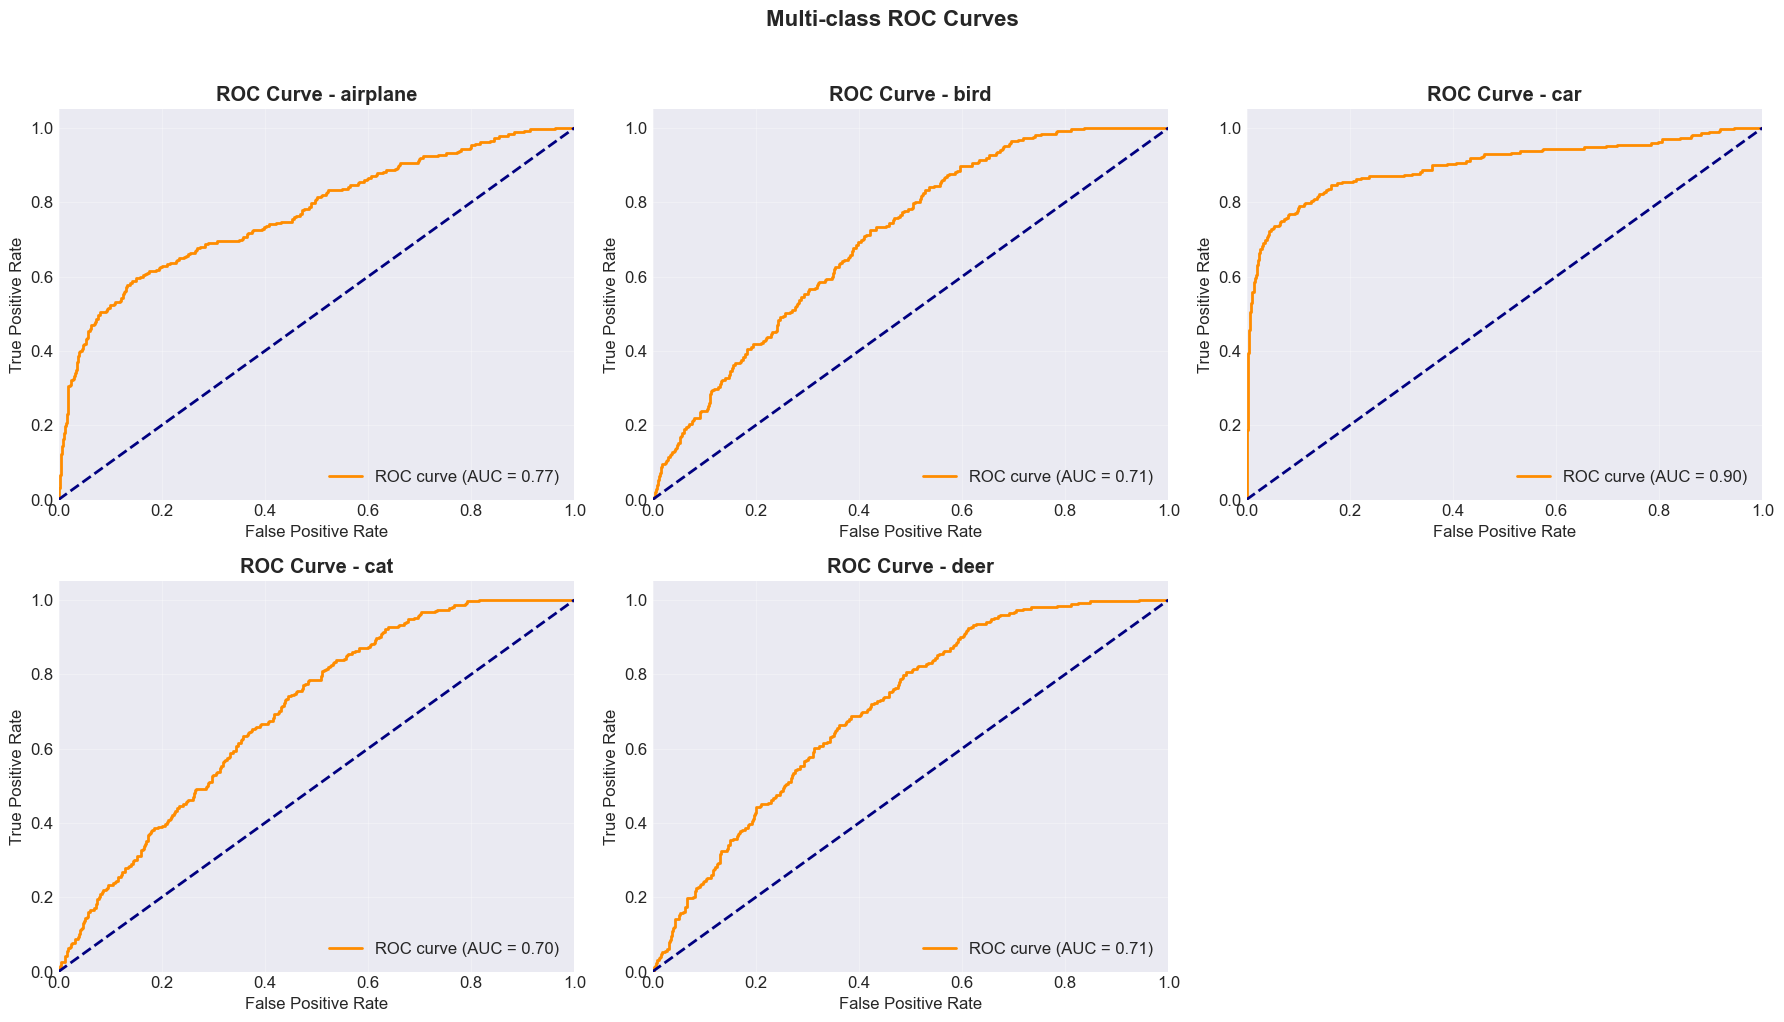


📊 AUC Scores for Each Class:
   airplane: AUC = 0.7711
   bird: AUC = 0.7066
   car: AUC = 0.8992
   cat: AUC = 0.6973
   deer: AUC = 0.7099

📈 Aggregate AUC Scores:
   Micro-average AUC: 0.7774
   Macro-average AUC: 0.7573


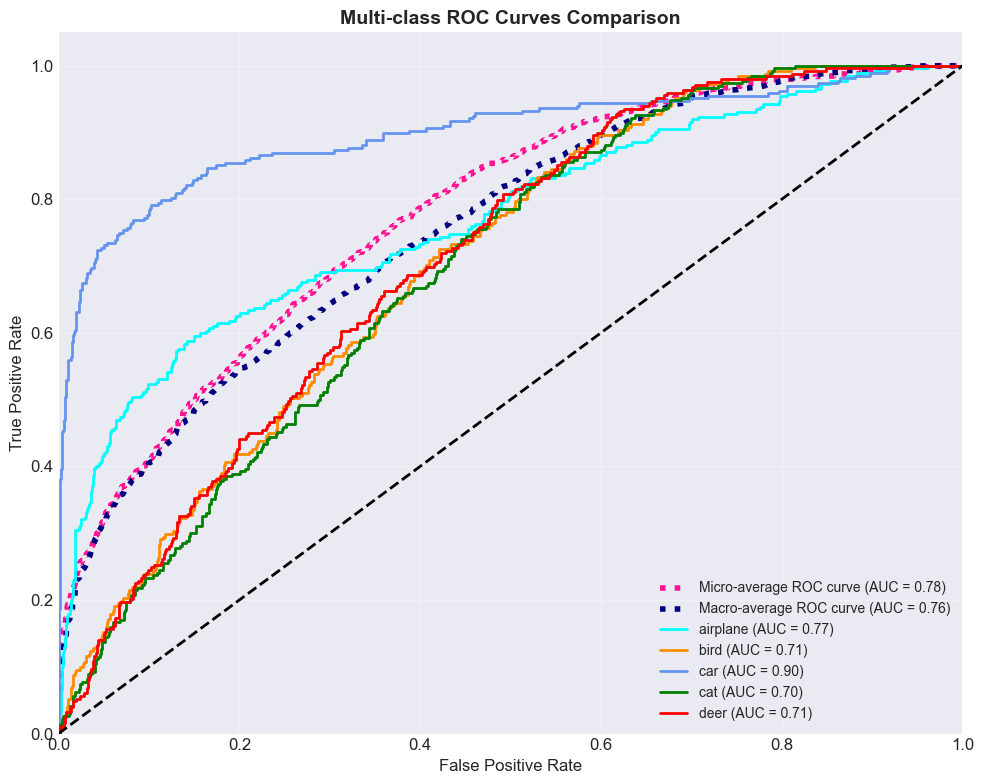

In [8]:
# ================== Cell 6.5: ROC Curves and AUC Scores ==================
print("📈 Generating ROC Curves and AUC Scores")
print("="*70)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
y_pred_proba = best_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

roc_data = {}
for i, class_name in enumerate(class_names):
    if i < len(axes):  # Handle case where we have more classes than subplots
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        roc_data[class_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
        
        # Plot ROC curve
        axes[i].plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].set_title(f'ROC Curve - {class_name}', fontweight='bold')
        axes[i].legend(loc="lower right")
        axes[i].grid(True, alpha=0.3)

# Hide empty subplot if we have less than 6 classes
if len(class_names) < 6:
    for i in range(len(class_names), 6):
        axes[i].set_visible(False)

plt.suptitle('Multi-class ROC Curves', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print AUC scores
print("\n📊 AUC Scores for Each Class:")
for class_name, data in roc_data.items():
    print(f"   {class_name}: AUC = {data['auc']:.4f}")

# Compute micro-average ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve
all_fpr = np.unique(np.concatenate([data['fpr'] for data in roc_data.values()]))
mean_tpr = np.zeros_like(all_fpr)
for data in roc_data.values():
    mean_tpr += np.interp(all_fpr, data['fpr'], data['tpr'])
mean_tpr /= len(class_names)
roc_auc_macro = auc(all_fpr, mean_tpr)

print(f"\n📈 Aggregate AUC Scores:")
print(f"   Micro-average AUC: {roc_auc_micro:.4f}")
print(f"   Macro-average AUC: {roc_auc_macro:.4f}")

# Plot aggregate ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr_micro, tpr_micro,
        label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})',
        color='deeppink', linestyle=':', linewidth=4)

ax.plot(all_fpr, mean_tpr,
        label=f'Macro-average ROC curve (AUC = {roc_auc_macro:.2f})',
        color='navy', linestyle=':', linewidth=4)

# Plot individual class ROC curves
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for idx, (class_name, data) in enumerate(roc_data.items()):
    ax.plot(data['fpr'], data['tpr'], color=colors[idx % len(colors)], lw=2,
            label=f'{class_name} (AUC = {data["auc"]:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multi-class ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Error Analysis

🔍 Error Analysis

Total misclassified samples: 690 (53.08%)

📊 Error Rate by Class:
   airplane: 112/262 (42.75%)
   bird: 169/251 (67.33%)
   car: 67/268 (25.00%)
   cat: 184/270 (68.15%)
   deer: 158/249 (63.45%)

🔀 Top Confusion Pairs:
   cat → bird: 65 samples
   cat → deer: 63 samples
   deer → cat: 59 samples
   bird → deer: 57 samples
   bird → cat: 50 samples

🎯 Confidence Analysis:
   Mean confidence in misclassifications: 0.390
   Std confidence in misclassifications: 0.114
   Min confidence in misclassifications: 0.230


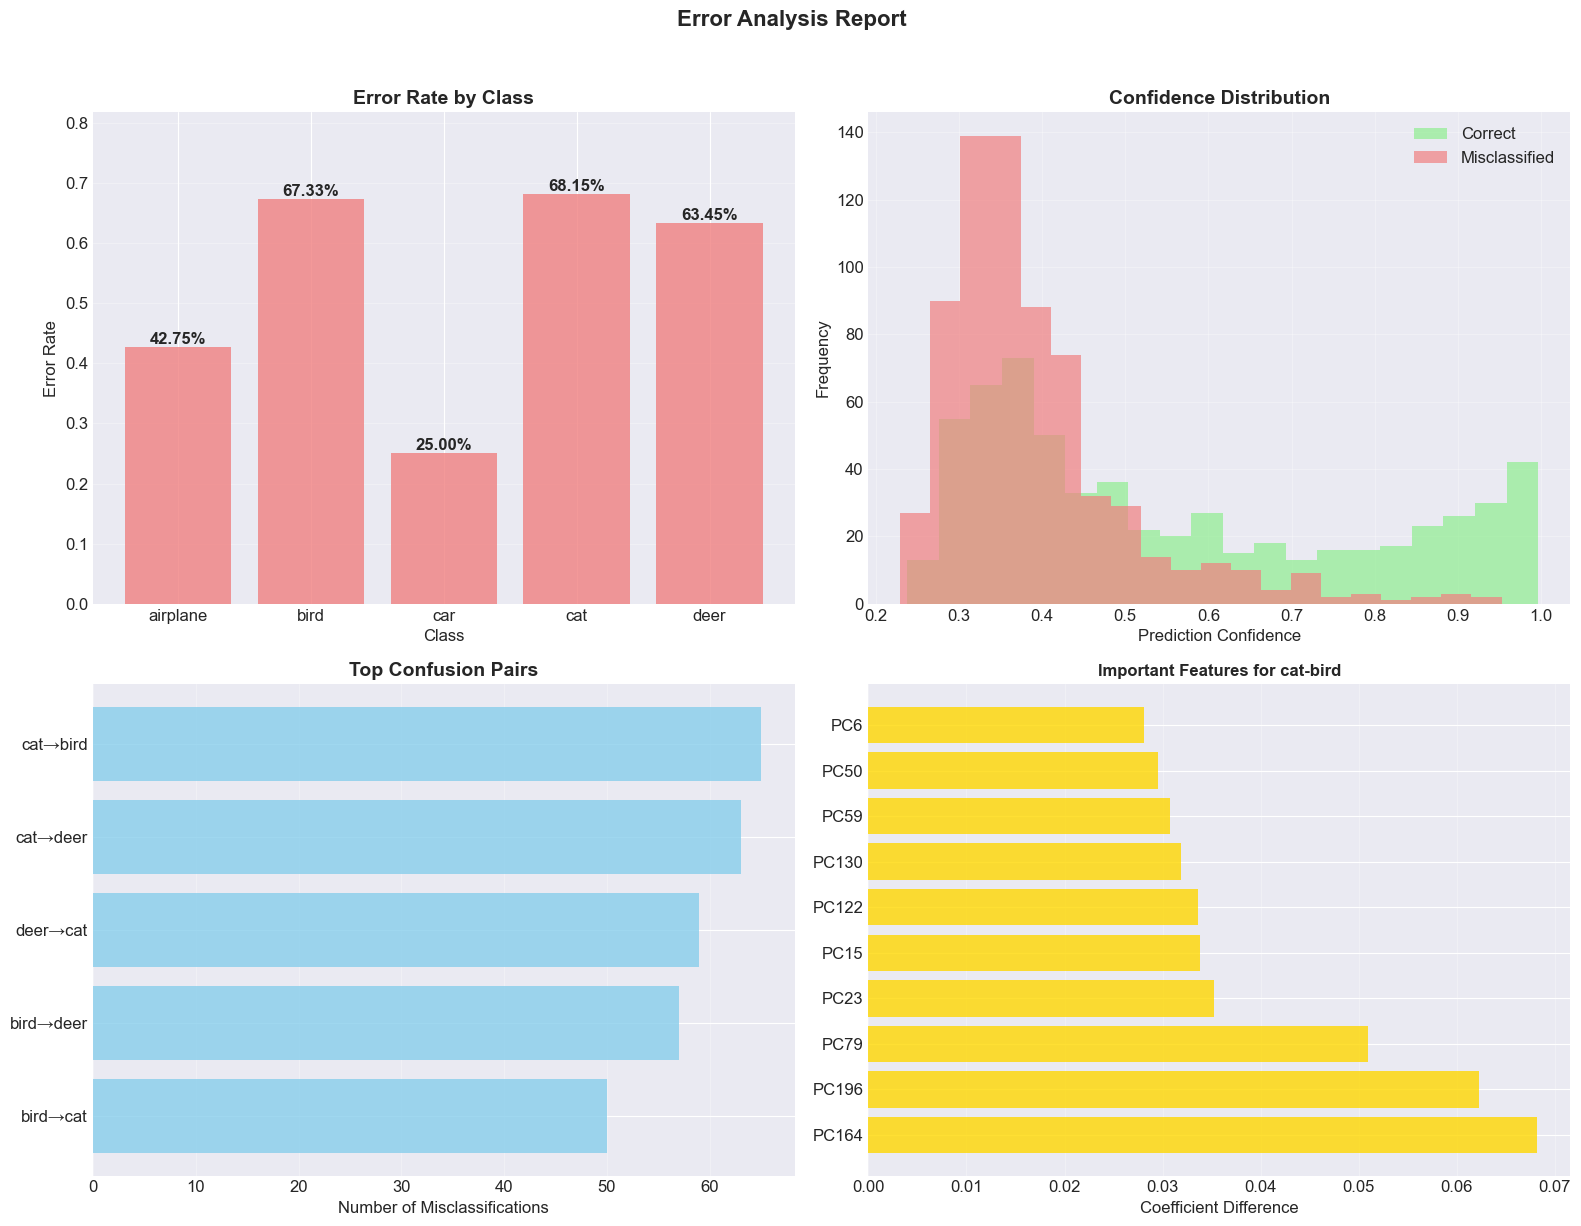

In [9]:
def analyze_errors(X_test, y_test, y_pred, y_pred_proba, class_names, pca, scaler):
    """
    Analyze misclassifications and difficult samples
    """
    print("🔍 Error Analysis")
    print("="*60)
    
    # Identify misclassified samples
    misclassified_idx = np.where(y_pred != y_test)[0]
    
    if len(misclassified_idx) == 0:
        print("✅ No misclassifications found!")
        return
    
    print(f"\nTotal misclassified samples: {len(misclassified_idx)} ({len(misclassified_idx)/len(y_test):.2%})")
    
    # Analyze by class
    misclass_by_class = {}
    for i in range(len(class_names)):
        class_idx = np.where(y_test == i)[0]
        misclass_in_class = np.sum(y_pred[class_idx] != y_test[class_idx])
        misclass_by_class[class_names[i]] = {
            'total': len(class_idx),
            'misclassified': misclass_in_class,
            'error_rate': misclass_in_class/len(class_idx) if len(class_idx) > 0 else 0
        }
    
    print("\n📊 Error Rate by Class:")
    for class_name, stats in misclass_by_class.items():
        print(f"   {class_name}: {stats['misclassified']}/{stats['total']} "
              f"({stats['error_rate']:.2%})")
    
    # Create confusion matrix for error analysis
    cm = confusion_matrix(y_test, y_pred)
    
    # Find most confused pairs
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j]))
    
    # Sort by frequency
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\n🔀 Top Confusion Pairs:")
    for i, j, count in confusion_pairs[:5]:
        print(f"   {class_names[i]} → {class_names[j]}: {count} samples")
    
    # Analyze confidence scores for misclassifications
    misclassified_confidences = []
    for idx in misclassified_idx:
        true_class = y_test[idx]
        pred_class = y_pred[idx]
        confidence = y_pred_proba[idx, pred_class]
        misclassified_confidences.append(confidence)
    
    print(f"\n🎯 Confidence Analysis:")
    print(f"   Mean confidence in misclassifications: {np.mean(misclassified_confidences):.3f}")
    print(f"   Std confidence in misclassifications: {np.std(misclassified_confidences):.3f}")
    print(f"   Min confidence in misclassifications: {np.min(misclassified_confidences):.3f}")
    
    # Visualize error patterns
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Error rate by class
    error_rates = [stats['error_rate'] for stats in misclass_by_class.values()]
    axes[0, 0].bar(class_names, error_rates, color='lightcoral', alpha=0.8)
    axes[0, 0].set_title('Error Rate by Class', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Error Rate')
    axes[0, 0].set_ylim(0, max(error_rates) * 1.2)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, rate in enumerate(error_rates):
        axes[0, 0].text(i, rate + 0.005, f'{rate:.2%}', 
                       ha='center', fontweight='bold')
    
    # 2. Confidence distribution for correct vs incorrect predictions
    correct_idx = np.where(y_pred == y_test)[0]
    correct_confidences = []
    for idx in correct_idx:
        pred_class = y_pred[idx]
        confidence = y_pred_proba[idx, pred_class]
        correct_confidences.append(confidence)
    
    axes[0, 1].hist(correct_confidences, bins=20, alpha=0.7, 
                   label='Correct', color='lightgreen')
    axes[0, 1].hist(misclassified_confidences, bins=20, alpha=0.7, 
                   label='Misclassified', color='lightcoral')
    axes[0, 1].set_title('Confidence Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Prediction Confidence')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Top confusion pairs
    if confusion_pairs:
        top_pairs = confusion_pairs[:5]
        pair_labels = [f'{class_names[i]}→{class_names[j]}' for i, j, _ in top_pairs]
        pair_counts = [count for _, _, count in top_pairs]
        
        axes[1, 0].barh(pair_labels, pair_counts, color='skyblue', alpha=0.8)
        axes[1, 0].set_title('Top Confusion Pairs', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Number of Misclassifications')
        axes[1, 0].invert_yaxis()
        axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # 4. Feature importance for top misclassifications (if available)
    if hasattr(best_model, 'coef_'):
        # Analyze coefficients for most confused class
        if confusion_pairs:
            class1, class2, _ = confusion_pairs[0]
            coef_diff = np.abs(best_model.coef_[class1] - best_model.coef_[class2])
            top_features = np.argsort(coef_diff)[-10:]  # Top 10 most important features
            
            axes[1, 1].barh(range(10), coef_diff[top_features], color='gold', alpha=0.8)
            axes[1, 1].set_title(f'Important Features for {class_names[class1]}-{class_names[class2]}', 
                               fontsize=12, fontweight='bold')
            axes[1, 1].set_xlabel('Coefficient Difference')
            axes[1, 1].set_yticks(range(10))
            axes[1, 1].set_yticklabels([f'PC{i+1}' for i in top_features])
            axes[1, 1].invert_yaxis()
            axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    plt.suptitle('Error Analysis Report', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return misclassified_idx

# Run error analysis
misclassified_idx = analyze_errors(X_test, y_test, y_pred_opt, y_pred_proba_opt, 
                                   class_names, pca, scaler)